# Topic Modeling

Topic models attempt to infer the hidden topic strucure of a document or corpus by analizing the words that make up a document.

***
**Run code block 1 on first use of this notebook**<br>
<br>
**Remember to run code blocks 3 before attempting to run other portions of this notebook**
***

## Set up / Instructions
This code is written for python3


**Install the gensim package in the same place as anaconda**

the following command should work

pip install gensim

**To change the corpus:**<br>
go to code block **4** and change the current path 'corpusIR' to the path to the desired corpus. This program expects a corpus to be a folder contaning text files. each individual text file is treated as a document.

In [1]:
#CODE BLOCK 1

#run this only on first use of this notebook
#this downloads data needed for the nltk lemmatizer and pos tagger

import nltk
nltk.download("wordnet")
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/edwardsja15/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/edwardsja15/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
#CODE BLOCK 2

# Run this code block if you want to see gensim log output.
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [12]:
#CODE BLOCK 3

%matplotlib inline

from gensim import corpora, models, similarities
import tempfile
from collections import defaultdict
from pprint import pprint #pretty printer
import os
import string
import re
from nltk.stem import WordNetLemmatizer
import random
import matplotlib.pyplot as plt
import operator
from decimal import Decimal
from nltk import pos_tag


#This variable controls the intensity of the text preprocessing.
#Its valid values are the inergers 1, 2 and 3.
#The lower the less intense the preprocessing.
#A value of 2 should be sufficent for training topic models.
textPreprocessingLevel = 2

#Define MyCorpus object
class MyCorpus(object):
    
    
    @staticmethod
    def createCorpus(docs):
        corp = MyCorpus()
        corp.docL = docs
        return corp

    def __init__(self):
        docL = []
    def __len__(self):
        return len(self.docL)
    
    @staticmethod
    def tokenizeDocLight(doc):
        docT = []
        for word in doc.lower().split():
            w = word.strip(string.punctuation)
            docT.append(w)
        
        return docT
    

    #returns list of tokens in lowercase split on whitespace with punctuation removed, lemmatized
    @staticmethod
    def tokenizeDocMedium(doc):
        wordnet_lemmatizer = WordNetLemmatizer()
        docT = []
        for word in doc.lower().split():
            w = word.strip(string.punctuation)
            w = wordnet_lemmatizer.lemmatize(w)
            if(w != ''):
                docT.append(w)

        return docT


    @staticmethod
    def tokenizeDocHeavy(doc):
        wordnet_lemmatizer = WordNetLemmatizer()
        docT = []
        wordLSplit = doc.lower().split()
        wordListPunctuationRemoved = []
        for word in wordLSplit:
            w = word.strip(string.punctuation)
            if(w != ''):
                wordListPunctuationRemoved.append(w)

        wordLTagged = pos_tag(wordListPunctuationRemoved)
        for wT in wordLTagged:
            if('NN' in wT[1]):
                docT.append(wordnet_lemmatizer.lemmatize(wT[0], pos='n'))
            elif('VB' in wT[1]):
                docT.append(wordnet_lemmatizer.lemmatize(wT[0], pos='v'))

        return docT
    
    def __iter__(self):
        if(textPreprocessingLevel == 1):
            tokenizeDoc = MyCorpus.tokenizeDocLight
        elif(textPreprocessingLevel == 2):
            tokenizeDoc = MyCorpus.tokenizeDocMedium
        elif(textPreprocessingLevel == 3):
            tokenizeDoc = MyCorpus.tokenizeDocHeavy
        else:
            print('WARNING: text preprocessing level not recognized, using medium level text preprocessing.')
            tokenizeDoc = tokenizeDocMedium
        
        for doc in self.docL:
            yield dictionary.doc2bow(tokenizeDoc(doc)) 



            
#------------------------------------------------------------#
# Functions for dictionary construction / text preprocessing #
#------------------------------------------------------------#

#getStopWordList(pathToSWL) returns a list of stopwords contained in file
#located at pathToSWL. 
#getStopWordList EXPECTS the stop words in the text file to be deliniated by whitespace
def getStopWordList(pathToSWL):
    #print('Reading stopword list from: ' + pathToSWL + '\n')

    f = open(pathToSWL, 'r')
    fcontents = f.read()
    stopWordList = fcontents.split()
    f.close()

    return stopWordList

def tokenizeCorpus(corpusList, pathToStopWordList):
    tokenizedCorpus = []
    
    #preprecessing level 1
    if(textPreprocessingLevel == 1):
        for doc in corpusList:
             tokenizedCorpus.append(tokenizeDocumentLight(doc))

    else:
        #read stop list, convert to set for faster stop word removal
        stoplist = getStopWordList(pathToStopWordList)
        stopSet = set(stoplist)
        
        #initalize the word net lemmatizer
        lemmatizer = WordNetLemmatizer()
        
        #compile regular expresion to remove numbers
        numberRemover = re.compile("[\d{}]+$".format(re.escape(string.punctuation)))
        
        #preprecessing level 2
        if(textPreprocessingLevel == 2):
            tokenizeDocumentWithSWR = tokenizeDocumentMedium
        
        #preprecessing level 3
        elif(textPreprocessingLevel == 3):
            tokenizeDocumentWithSWR = tokenizeDocumentHeavy
        else:
            print('WARNING: text preprocessing level not recognized, using medium level text preprocessing.')
            tokenizeDocument = tokenizeDocMedium
        
        for doc in corpusList:
            tokenizedCorpus.append(tokenizeDocumentWithSWR(doc, stopSet, lemmatizer, numberRemover))
    
    return tokenizedCorpus
            
def tokenizeDocumentLight(doc):
    docTokenized = []
    for word in doc.lower().split():
        w = word.strip(string.punctuation) #remove trailing punctuation
        if(w != ''):
            docTokenized.append(w)
    return docTokenized

def tokenizeDocumentMedium(doc, stopSet, lemmatizer, numberRemover):
    docTokenized = []
    for word in doc.lower().split():
        w = word.strip(string.punctuation)
        w = lemmatizer.lemmatize(w)
        if(w not in stopSet and w != '' and not numberRemover.match(w)):
            docTokenized.append(w)
            
    return docTokenized
    
def tokenizeDocumentHeavy(doc, stopSet, lemmatizer, numberRemover):
    docTokenized = []
    tokensUntagged = []
    for word in doc.lower().split():
        w = word.strip(string.punctuation)
        if(w not in stopSet and w != '' and not numberRemover.match(w)):
            tokensUntagged.append(w)
    
    #tokensTagged is a list of tupes of the form (token as a string, part of speech tag as a string)
    #see nltk's documentation for more information
    tokensTagged = pos_tag(tokensUntagged)
    for wordTagged in tokensTagged:
        #keep words tagged as nouns or verbs
        if('NN' in wordTagged[1]):
            w = lemmatizer.lemmatize(wordTagged[0], pos='n')
        elif('VB' in wordTagged[1]):
            w = lemmatizer.lemmatize(wordTagged[0], pos='v')
        else:
            w = ''
            
        if(w != '' and w not in stopSet):
            docTokenized.append(w)
    
    return docTokenized


#------------------#
# Helper Functions #
#------------------#


#corpusSourceToListOfDocuments returns all the content of all documents in folder path
#as a list of strings.
#path is the path to the folder containing the corpus
def corpusSourceToListOfDocumets(path):
    corpusL = []
    for filename in os.listdir(path):
        fullpath = path + '/' + filename
        if(filename[0] != '.'):
            f = open(fullpath, 'r')
            fcontents = f.read()
            corpusL.append(fcontents)
            f.close()

    return corpusL

def showTopicModelAsTable(tm, numTopics, numKeywords, tableName):
    topicList = []
    for i in range(0, numTopics):
        row = []
        row.append(i)

        keyWordList = tm.show_topic(i, topn=numKeywords)
        
        #get just the keywords
        for k in keyWordList:
            row.append(k[0])

        topicList.append(row)

    #build list of column names
    colLabels = ['Topic Number']
    i = 0
    while(i < (len(topicList[0]) - 1)):
        colLabels.append('Keyword ' + str(i+ 1))
        i += 1
   
    #build list of column widths
    widths = [0.18]
    i = 0
    while(i < (len(topicList[0]) - 1)):
        widths.append(0.17)
        i += 1
    
    #draw table
  
    fig, ax = plt.subplots(figsize=(10,3))
    #fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    tbl = ax.table(cellText=topicList, colLabels=colLabels, cellLoc='center', loc='lower left', colWidths=widths)

    tbl.auto_set_font_size(False)

    tbl.set_fontsize(40)
    tbl.scale(3,6)
    plt.tight_layout()
    plt.show()
    
    tmTableToCSV('./figures/' + tableName + '.csv', colLabels, topicList)
    
def tmTableToCSV(fname, colLabels, tableContents):
    with open(fname, 'w+') as f:
        i = 0
        colLablesJoinend = '","'.join(colLabels)
        colLablesStr = '"' + colLablesJoinend + '"\n'
        f.write(colLablesStr)
        for row in tableContents:
            rowStr = '"' + '","'.join(map(str, row)) + '"\n'
            f.write(rowStr)
            
def graphToCSV(axisLabels, x, y, fname):
    with open(fname, 'w+') as f:
        f.write('"' + '","'.join(axisLabels) + '"\n')
        
        i = 0
        while(i < len(x)):
            f.write('"' + str(x[i]) + '","' + str(y[i]) + '"\n')
            i += 1
    


### Read in and Process Corpus

In [4]:
#CODE BLOCK 4

#read corpus into memory
#a corpus is a list of strings where each string is viewed as a document

#change 'corpusIR' to a different path to read in a different corpus
#the path should be the path to the folder containing the corpus of text documents

corpusList = corpusSourceToListOfDocumets('corpusIR')

### Traning a Basic Topic Model

This code trains a basic LDA model for numTopics topics. 

In [ ]:
#tokenizedCorpus is a list of lists of strings
#each list of strings corresponds to the tokens that maked up the document in corpusList 
tokenizedCorpus = tokenizeCorpus(corpusList, 'stopwords.txt')

#creates the dictionary for the topic model
#a dictionary is the collection of all words that the model should consider possible indicators of a topic
dictionary = corpora.Dictionary(tokenizedCorpus)

#creates a corpus object for gensim
theCorpus = MyCorpus.createCorpus(corpusList)

#build tfidf model of theCorpus
tfidf = models.TfidfModel(theCorpus)

#convert corpus from bag of words to tfidf vectors
corpus_tfidf = tfidf[theCorpus]

numTopics = 15
lda = models.LdaModel(theCorpus, id2word=dictionary, num_topics=numTopics, passes=7, update_every=2, iterations=300)

pprint(lda.print_topics(num_topics=numTopics, num_words=10))

***
# Topic Modeling Algorithms

## Latent Dirichlet Allocation (LDA)
<br>
**Assumptions of LDA**
- A document can express multiple topics in different proportions
- The corpus is comprised of a fixed number of topics, K
- Topics are hidden variables
- Documents are "bags of words", meaning the order of words in the text is not considered

**Mathematical Description of LDA**

$$ p(\beta_{1:K},\theta_{1:D},z_{1:D},w_{1:D}) = \prod_{i=1}^K p(\beta_i) \times \prod_{d=1}^D p(\theta_d) \times \big(\prod_{n=1}^N p(z_{d,n}\mid\theta_d)\times p(w_{d,n}\mid\beta_{1:K},z_{d,n})\big) \quad(1)$$
<br>
$\beta_{k}$ \- is a distribution over the vocabulary for the $k$th topic<br>
$\theta_d$ \- is the topic proportions for the $d$th document <br>
$\theta_{d,k}$ \- is the topic proportion of the $k$th topic in document $d$ <br>
$z_d$ \- is the topic assignments for the $d$th document <br>
$z_{d,n}$ \- is the topic assignment of the $n$th word in document $d$ <br>
$w_d$ \- are the observed words for document $d$, all words in $w_d$ are members of the fixed vocabulary <br>
$w_{d,n}$ \- is the $n$th word in document $d$ <br>
<br>
The Equation below is the posterior for LDA:<br>
$$p(\beta_{1:K}, \theta_{1:D}, z_{1:D} \mid w_{1:D}) = \frac{p(\beta_{1:K}, \theta_{1:D}, z_{1:D}, w_{1:D})}{p(w_{1:D})} \quad (2)$$

The denominator of equation 2 is effectively incomputable for a corpus of any reasonable size since it involves assessing all possible assignments of all words to all possible topics. Gibbs sampling is one method used to approximate  $p(w_{1:D})$.

<br>

http://www.cs.columbia.edu/~blei/papers/BleiLafferty2009.pdf [1]<br>
http://www.cs.columbia.edu/~blei/papers/Blei2012.pdf [2]


## Latent Semantic Indexing (LSI)
Also referred to as Latent Semantic Analysis (LSA). LSI was created as an information retrieval tool with the goal of better handling synonymy and polysemy.

**Assumptions of LSI**
- bag of words

<br>
**Mathematical Description of LSI**<br>
A term by document matrix $M$ is constructed from the corpus, with terms as the rows and documents as the columns.
<br>$M_{t,d}$ holds the term frequency for term $t$ in document $d$


Singular Value Decomposition (SVD) is performed on $M$ <br>
SVD is defined in this context as: <br>
$$M = T_0\times S_0 \times D_0'$$<br>
$T_0$ \- is a $t$ by $m$ matrix that has orthogonal unit-length columns, where $T_0 ' T_0 = I$<br>
$D_0$ \- is a $m$ by $d$ matrix that has orthogonal unit-length columns, where $D_0 ' D_0 = I$<br>
$S_0$ \- is a $m$ by $m$ diagonal matrix of singular values<br>
$t$ \- is the number of row of $M$, the number of terms<br>
$d$ \- is the number of columns in $M$, the number of documents<br>
$m$ \- is the rank of $M$, where $m \leq min(t, d)$ <br>

In practice the resulting matrices of the SVD of matrix $M$ are approximated (to reduce computations) by reduced SVD:
$$X \approx \hat{X} = T \times S \times D'$$
The notation for this formula is similar to equation 2, the changes are noted below<br>
$T$ \- is a $t$ by $k$ matrix <br>
$D$ \- is a $k$ by $d$ matrix <br>
$S$ \- is a $k$ by $k$ matrix<br>
$k$ \- is the rank of $S$, where $k \leq m$ <br>
<br>This approach serves as a sort of dimensionality reduction

Document Similarities and word similarities can be calculated by doing operations on the matrices generated from the reduced SVD. <br>

The similarity of two terms can be computed by taking the dot product of a row $i$ and a row $j$ of matrix $TS$<br>
The similarity of two documents can be computed by taking the dot product of a row $i$ and a row $j$ of matrix $DS$<br>
<br>
It should be noted that there are also probabilistic versions of LSI [5]

(see section 4.2 of Indexing by Latent Semantic Analysis, Derwester et. al. for an in-depth explanation) <br>

http://lsa.colorado.edu/papers/JASIS.lsi.90.pdf [3] (equations taken from this source)<br>
http://173.236.226.255/tom/papers/SteyversGriffiths.pdf [4]<br>
http://www.iro.umontreal.ca/~nie/IFT6255/Hofmann-UAI99.pdf [5] (covers pobabaistic LSI) <br>


## Hierarchical Dirichlet Process (HDP)

A Nonparametric approach to Topic Modeling. Meaning the number of topics does not need to be specified in advance. HDP infers the number of topics from the corpus.

**Mathematical Description of HDP**<br>
At a high level a HDP is defined as a collection of Dirichlet processes where:
$$G_0 \sim DP(\gamma H)$$<br>
$$G_j \sim DP(\alpha_0 G_0), \text{ for each }j$$
<br>
$G_0$ \- is the base distribution, drawn from a Dirichlet process<br>
$j$ \- is an index for each group of data
<br>
To generate topics:<br>

$$\theta_{jn} \sim G_j$$<br>
where $\theta_{jn}$ is the topic asiciated with the $n$th word in the $j$th document
$$w_{jn} \sim \text{Mult}(\theta_{jn})$$ <br>
where $w_{jn}$ is the word from topic $\theta_{jn}$

<br>
http://proceedings.mlr.press/v15/wang11a/wang11a.pdf [6] (where equations were drawn from)<br>
Other useful refrence:<br>
https://amstat.tandfonline.com/doi/abs/10.1198/016214506000000302#.Wyv6w4InZUM (not used)


***
## Topic Model Evaluation
There a several ways to measure the effectiveness of topic models the two main metrics are perplexity and coherence. Other approaches like measuring a topic models performance on other task like information retrieval or document classification are also used.

### Perplexity
Perplexity assesses the extent to which the model is confused by a set of held out documents belonging to the same corpus. The lower the perplexity the better. To evaluate a model using perplexity a subset of the documents in the corpus should be randomly selected and withheld as a test set. The performance of the model can then be evaluated on the unseen test set. 

**Defined for LDA as:**<br>
$$perplexity(D_{test}) = exp \bigg(-\frac{\sum^D_{d=1}\log p(w_d)}{\sum^D_{d=1} N_d} \bigg)$$

$D_{test}$ \- is the collection of held out documents<br>
$D$ \- is the number of documents in $D_{test}$<br>
$N_d$ \- is the number of words in document $d$<br>

http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf [7] section 7.1


### Coherence
Coherence servers as a measure of the human interpretability of a given topic model. the higher the coherence the better. There are several methods for computing coherence some are listed below.

**UCI Coherence:**<br>
$$C_{UCI} = \frac{2}{N\cdot(N-1)} \sum^{N-1}_{i=1}\sum^N_{j=i+1} PMI(w_i,w_j)$$
$$PMI(w_i,w_j)=\log \frac{p(w_i,w_j) + \epsilon}{p(w_i) \cdot p(w_j)}$$

$N$ \- is the top number of terms from some topic $t$<br>
$w_i$ \- is the $i$th word from the top $N$ words of topic $t$<br>
$\epsilon$ \- is a small constant to prevent taking the log of $0$, $0 < \epsilon \leq 1$<br>
Word probabilities are calculated based on word co-occurrence counts.

**UMass Coherence:**<br>
$$C_{UMass} = \frac{2}{N\cdot(N-1)} \sum^{N}_{i=2}\sum^{i-1}_{j=1} \log \frac{p(w_i,w_j) + \epsilon}{p(w_j)})$$
The notation remains the same except word probabilities are estimated using document frequencies from the training documents. 

**CV Coherence:**<br>
"$C_V$ combines  the  indirect  cosine  measure  with  the
NPMI and the boolean sliding window."<br>

NOTE: I was not able to find an explicit definition of $C_V$, the qoute above is the best explination that the paper provides. The paper linked is where $C_V$ coherence is originally propsed.

<br>http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf [8]
***

## Building the Best Model
### Text Preprocessing

Text preprocessing is of great importance when training Topic Models. Preprocessing greatly affects the resulting model. The usefulness of the model can be greatly affected by the words that are included in the vocabulary, called a dictionary in gensim. Stop words like *the* and *of* provide little information about the subject of a document. When stop words are allowed in the model they overpower the more meaningful words since the occur so frequently. <br>

The code below trains three LDA topic models each employing different a method for text preprocessing. See code blocks 3 and 4 for definitions. The code refers to these methods of text preprocessing as "light", "medium", and "heavy", the models are trained and presented in that order. This is not an exhaustive list of text preprocessing methods but is instead present to show the effect of bad preprocessing.<br>


**Minimal Preprocessing** (light)<br>
Documents are lowercased and split on whitespace. Punctuation is striped from the resulting tokens.<br> 

**Stop Word Removal** (medium)<br>
All of the previous steps are taken with the addition of stop word removal using the Stanford stop list with minor additions. tokens consisting of only number characters are also removed. Tokens are then lemmatized with the word net lemmatizer.

**Part of Speech Tagging** (heavy)<br>
A unigram part of speech tagger is used. tokens tagged not tagged as nouns or verbs are removed. tokens are then lemmatized according to their part of speech tag, this leads to better lemmatization. This method is very computationally expensive and could be unreasonable for a very large corpus.

In [ ]:
#code for text preprocessing evaluation
textPreprocessingLevel = 1
numTopics = 10

tableTitles = ['Minimal_Preprocessing','Stop_Word_Removal','Part_of_Speech_Tagging']

while(textPreprocessingLevel <= 3):
    tokenizedCorpus = tokenizeCorpus(corpusList, 'stopwords.txt')
    dictionary = corpora.Dictionary(tokenizedCorpus)
    
    theCorpus = MyCorpus.createCorpus(corpusList)
    
    tfidf = models.TfidfModel(theCorpus)
    corpus_tfidf = tfidf[theCorpus]
    
    lda = models.LdaModel(theCorpus, id2word=dictionary, num_topics=numTopics, passes=10, update_every=2, iterations=300)
    print('\t\t\t\t\t\t' + tableTitles[textPreprocessingLevel - 1])
    
    #Tables produced by this code are written to: 
    #   "./figures/Minimal_Preprocessing.csv"
    #   "./figures/Stop_Word_Removal.csv"
    #   "./figures/Part_of_Speech_Tagging.csv"
    #respectively as the loop executes
    showTopicModelAsTable(lda, numTopics, 10, tableTitles[textPreprocessingLevel - 1])
    
    textPreprocessingLevel += 1
    
textPreprocessingLevel = 2

### Choosing the Number of Topics (LDA and LSI)
This code generates graphs comparing number of topics to model coherence. **Run the block below to initalize necesary functions for generating the graphs.** Then you can run the other blocks to see the graphs

In [13]:
#code for generating topic graphs

def evaluateLSINumTopicsGraph(dictionary, corpus, texts, limit):
    c_v = []
    lm_list = []
    for num_topics in range(1, limit + 1):
        print('\n===========================     Training on ' + str(num_topics) + ' topics     ===========================\n')
        lm = models.LsiModel(corpus, id2word=dictionary, num_topics=num_topics, power_iters=150, extra_samples=5)
        lm_list.append(lm)
        topics = []
        for topic_id, topic in lm.show_topics(num_topics=num_topics, formatted=False):
            topic = [word for word, _ in topic]
            topics.append(topic)
        cm = models.CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())

    # Show graph
    x = range(1, limit + 1)
    plt.plot(list(x), c_v)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence")
    plt.show()
    
    graphToCSV(["Number of Topics", "Coherence"], x, c_v, './figures/LSI_NUM_Topic_Graph.csv')

    return (lm_list, c_v)

def evaluateLDANumTopicsGraph(dictionary, corpus, texts, limit):
    c_v = []
    lm_list = []
    for num_topics in range(1, limit + 1):
        print('\n===========================     Training on ' + str(num_topics) + ' topics     ===========================\n')
        lm = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,  passes=5, update_every=2, iterations=250, alpha='auto', eta='auto')
        lm_list.append(lm)
        cm = models.CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())

    # Show graph
    x = range(1, limit + 1)
    plt.plot(list(x), c_v)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence")
    plt.show()
    
    graphToCSV(["Number of Topics", "Coherence"], x, c_v, './figures/LDA_NUM_Topic_Graph.csv')
    
    return (lm_list, c_v)

#shows table of topNkeywords of best topNtopics for topic model tm, uses coherence to evaluate topic
def showBestTopics(tm, texts, dictionary, windowSize, topNTopics, topNKeywords, tableName):
    coherence_values = {}
    for n, topic in tm.show_topics(num_topics=tm.num_topics, formatted=False):
        topic = [word for word, _ in topic]
        cm = models.CoherenceModel(topics=[topic], texts=texts, dictionary=dictionary, window_size=windowSize, coherence='c_v')
        coherence_values[n] = cm.get_coherence()

    coherence_values = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)


    #bestTopicList is a list of lists of the form [topic number, topic coherence, keyword 1, keyword 2, ..., keyword n])
    bestTopicList = []
    for i in range(0, topNTopics):
        #print('topic number: ' + str(coherence_values[i][0]) + ', topic coherence: ' + str(coherence_values[i][1]))
        
        L = []
        L.append(coherence_values[i][0])
        L.append(round(Decimal(coherence_values[i][1]), 3))

        kwL = tm.show_topic(coherence_values[i][0], topn=topNKeywords)

        keywordOnly = []
        for k in kwL:
            keywordOnly.append(k[0])

        L.extend(keywordOnly)
        bestTopicList.append(L)

    #draw table
    colLabels = ['Topic Number', 'Coherence']
    i = 0
    while(i < (len(bestTopicList[0]) - 2)):
        colLabels.append('Keyword ' + str(i+ 1))
        i += 1

    widths = [0.18, 0.18]
    i = 0
    while(i < (len(bestTopicList[0]) - 2)):
        widths.append(0.17)
        i += 1

    
    fig, ax = plt.subplots(figsize=(10,3))
    #fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    tbl = ax.table(cellText=bestTopicList, colLabels=colLabels, cellLoc='center', loc='lower left', colWidths=widths)
    tbl.auto_set_font_size(False)

    tbl.set_fontsize(40)
    tbl.scale(3,6)
    
    tmTableToCSV('./figures/' + tableName + '.csv', colLabels, bestTopicList)
    
    plt.tight_layout()
    plt.show()

#gets best tm from data generated in evaluatenNumTopicsGraph functions
#returns the best model
def getBestModelFromEvalBestTopic(modelListCoherenceTuple):
    bestScore = (0, 0)
    i = 1

    for cv in modelListCoherenceTuple[1]:
        if(cv > bestScore[1]):
            bestScore = (i, cv)

        i += 1

    print('The Best model has ' + str(bestScore[0]) + ' topics with ' + str(bestScore[1]) + ' coherence.')
    return modelListCoherenceTuple[0][bestScore[0] - 1]

### LSI

2018-06-28 15:09:07,842 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-06-28 15:09:07,920 : INFO : built Dictionary(7370 unique tokens: ['allow', 'aspect', 'broader', 'comment', 'complete']...) from 289 documents (total 87155 corpus positions)
2018-06-28 15:09:07,922 : INFO : collecting document frequencies
2018-06-28 15:09:07,924 : INFO : PROGRESS: processing document #0
2018-06-28 15:09:08,996 : INFO : calculating IDF weights for 289 documents and 7369 features (47298 matrix non-zeros)
2018-06-28 15:09:09,021 : INFO : using serial LSI version on this node
2018-06-28 15:09:09,023 : INFO : updating model with new documents



===========================     Training on 1 topics     ===========================



2018-06-28 15:09:10,401 : INFO : preparing a new chunk of documents
2018-06-28 15:09:10,417 : INFO : using 5 extra samples and 50 power iterations
2018-06-28 15:09:10,418 : INFO : 1st phase: constructing (7370, 6) action matrix
2018-06-28 15:09:10,420 : INFO : orthonormalizing (7370, 6) action matrix
2018-06-28 15:09:10,498 : INFO : 2nd phase: running dense svd on (6, 289) matrix
2018-06-28 15:09:10,500 : INFO : computing the final decomposition
2018-06-28 15:09:10,501 : INFO : keeping 1 factors (discarding 66.482% of energy spectrum)
2018-06-28 15:09:10,503 : INFO : processed documents up to #289
2018-06-28 15:09:10,507 : INFO : topic #0(3.861): 0.226*"clustering" + 0.172*"cluster" + 0.155*"model" + 0.143*"query" + 0.142*"relevance" + 0.142*"classification" + 0.130*"feedback" + 0.128*"vector" + 0.128*"class" + 0.121*"document"
2018-06-28 15:09:10,511 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2018-06-28 1


===========================     Training on 2 topics     ===========================



2018-06-28 15:09:12,483 : INFO : preparing a new chunk of documents
2018-06-28 15:09:12,498 : INFO : using 5 extra samples and 50 power iterations
2018-06-28 15:09:12,499 : INFO : 1st phase: constructing (7370, 7) action matrix
2018-06-28 15:09:12,502 : INFO : orthonormalizing (7370, 7) action matrix
2018-06-28 15:09:12,579 : INFO : 2nd phase: running dense svd on (7, 289) matrix
2018-06-28 15:09:12,580 : INFO : computing the final decomposition
2018-06-28 15:09:12,581 : INFO : keeping 2 factors (discarding 51.654% of energy spectrum)
2018-06-28 15:09:12,583 : INFO : processed documents up to #289
2018-06-28 15:09:12,585 : INFO : topic #0(3.861): 0.226*"clustering" + 0.172*"cluster" + 0.155*"model" + 0.143*"query" + 0.142*"relevance" + 0.142*"classification" + 0.130*"feedback" + 0.128*"vector" + 0.128*"class" + 0.121*"document"
2018-06-28 15:09:12,586 : INFO : topic #1(2.925): -0.648*"clustering" + -0.430*"cluster" + -0.162*"single-link" + -0.159*"similarity" + -0.127*"centroid" + -0.1


===========================     Training on 3 topics     ===========================



2018-06-28 15:09:14,617 : INFO : preparing a new chunk of documents
2018-06-28 15:09:14,634 : INFO : using 5 extra samples and 50 power iterations
2018-06-28 15:09:14,635 : INFO : 1st phase: constructing (7370, 8) action matrix
2018-06-28 15:09:14,637 : INFO : orthonormalizing (7370, 8) action matrix
2018-06-28 15:09:14,727 : INFO : 2nd phase: running dense svd on (8, 289) matrix
2018-06-28 15:09:14,729 : INFO : computing the final decomposition
2018-06-28 15:09:14,730 : INFO : keeping 3 factors (discarding 43.253% of energy spectrum)
2018-06-28 15:09:14,732 : INFO : processed documents up to #289
2018-06-28 15:09:14,734 : INFO : topic #0(3.861): 0.226*"clustering" + 0.172*"cluster" + 0.155*"model" + 0.143*"query" + 0.142*"relevance" + 0.142*"classification" + 0.130*"feedback" + 0.128*"vector" + 0.128*"class" + 0.121*"document"
2018-06-28 15:09:14,735 : INFO : topic #1(2.925): -0.648*"clustering" + -0.430*"cluster" + -0.162*"single-link" + -0.159*"similarity" + -0.127*"centroid" + -0.1


===========================     Training on 4 topics     ===========================



2018-06-28 15:09:16,784 : INFO : preparing a new chunk of documents
2018-06-28 15:09:16,799 : INFO : using 5 extra samples and 50 power iterations
2018-06-28 15:09:16,801 : INFO : 1st phase: constructing (7370, 9) action matrix
2018-06-28 15:09:16,803 : INFO : orthonormalizing (7370, 9) action matrix
2018-06-28 15:09:16,890 : INFO : 2nd phase: running dense svd on (9, 289) matrix
2018-06-28 15:09:16,892 : INFO : computing the final decomposition
2018-06-28 15:09:16,893 : INFO : keeping 4 factors (discarding 36.786% of energy spectrum)
2018-06-28 15:09:16,895 : INFO : processed documents up to #289
2018-06-28 15:09:16,897 : INFO : topic #0(3.861): 0.226*"clustering" + 0.172*"cluster" + 0.155*"model" + 0.143*"query" + 0.142*"relevance" + 0.142*"classification" + 0.130*"feedback" + 0.128*"vector" + 0.128*"class" + 0.121*"document"
2018-06-28 15:09:16,898 : INFO : topic #1(2.925): -0.648*"clustering" + -0.430*"cluster" + -0.162*"single-link" + -0.159*"similarity" + -0.127*"centroid" + -0.1


===========================     Training on 5 topics     ===========================



2018-06-28 15:09:19,029 : INFO : preparing a new chunk of documents
2018-06-28 15:09:19,044 : INFO : using 5 extra samples and 50 power iterations
2018-06-28 15:09:19,046 : INFO : 1st phase: constructing (7370, 10) action matrix
2018-06-28 15:09:19,048 : INFO : orthonormalizing (7370, 10) action matrix
2018-06-28 15:09:19,150 : INFO : 2nd phase: running dense svd on (10, 289) matrix
2018-06-28 15:09:19,152 : INFO : computing the final decomposition
2018-06-28 15:09:19,154 : INFO : keeping 5 factors (discarding 32.064% of energy spectrum)
2018-06-28 15:09:19,155 : INFO : processed documents up to #289
2018-06-28 15:09:19,157 : INFO : topic #0(3.861): 0.226*"clustering" + 0.172*"cluster" + 0.155*"model" + 0.143*"query" + 0.142*"relevance" + 0.142*"classification" + 0.130*"feedback" + 0.128*"vector" + 0.128*"class" + 0.121*"document"
2018-06-28 15:09:19,159 : INFO : topic #1(2.925): -0.648*"clustering" + -0.430*"cluster" + -0.162*"single-link" + -0.159*"similarity" + -0.127*"centroid" + -


===========================     Training on 6 topics     ===========================



2018-06-28 15:09:21,278 : INFO : preparing a new chunk of documents
2018-06-28 15:09:21,293 : INFO : using 5 extra samples and 50 power iterations
2018-06-28 15:09:21,295 : INFO : 1st phase: constructing (7370, 11) action matrix
2018-06-28 15:09:21,297 : INFO : orthonormalizing (7370, 11) action matrix
2018-06-28 15:09:21,409 : INFO : 2nd phase: running dense svd on (11, 289) matrix
2018-06-28 15:09:21,411 : INFO : computing the final decomposition
2018-06-28 15:09:21,412 : INFO : keeping 6 factors (discarding 28.776% of energy spectrum)
2018-06-28 15:09:21,414 : INFO : processed documents up to #289
2018-06-28 15:09:21,416 : INFO : topic #0(3.861): 0.226*"clustering" + 0.172*"cluster" + 0.155*"model" + 0.143*"query" + 0.142*"relevance" + 0.142*"classification" + 0.130*"feedback" + 0.128*"vector" + 0.128*"class" + 0.121*"document"
2018-06-28 15:09:21,418 : INFO : topic #1(2.925): -0.648*"clustering" + -0.430*"cluster" + -0.162*"single-link" + -0.159*"similarity" + -0.127*"centroid" + -


===========================     Training on 7 topics     ===========================



2018-06-28 15:09:23,562 : INFO : preparing a new chunk of documents
2018-06-28 15:09:23,577 : INFO : using 5 extra samples and 50 power iterations
2018-06-28 15:09:23,579 : INFO : 1st phase: constructing (7370, 12) action matrix
2018-06-28 15:09:23,581 : INFO : orthonormalizing (7370, 12) action matrix
2018-06-28 15:09:23,692 : INFO : 2nd phase: running dense svd on (12, 289) matrix
2018-06-28 15:09:23,694 : INFO : computing the final decomposition
2018-06-28 15:09:23,695 : INFO : keeping 7 factors (discarding 25.993% of energy spectrum)
2018-06-28 15:09:23,697 : INFO : processed documents up to #289
2018-06-28 15:09:23,699 : INFO : topic #0(3.861): 0.226*"clustering" + 0.172*"cluster" + 0.155*"model" + 0.143*"query" + 0.142*"relevance" + 0.142*"classification" + 0.130*"feedback" + 0.128*"vector" + 0.128*"class" + 0.121*"document"
2018-06-28 15:09:23,700 : INFO : topic #1(2.925): -0.648*"clustering" + -0.430*"cluster" + -0.162*"single-link" + -0.159*"similarity" + -0.127*"centroid" + -


===========================     Training on 8 topics     ===========================



2018-06-28 15:09:25,791 : INFO : preparing a new chunk of documents
2018-06-28 15:09:25,806 : INFO : using 5 extra samples and 50 power iterations
2018-06-28 15:09:25,808 : INFO : 1st phase: constructing (7370, 13) action matrix
2018-06-28 15:09:25,810 : INFO : orthonormalizing (7370, 13) action matrix
2018-06-28 15:09:25,932 : INFO : 2nd phase: running dense svd on (13, 289) matrix
2018-06-28 15:09:25,934 : INFO : computing the final decomposition
2018-06-28 15:09:25,936 : INFO : keeping 8 factors (discarding 23.603% of energy spectrum)
2018-06-28 15:09:25,938 : INFO : processed documents up to #289
2018-06-28 15:09:25,940 : INFO : topic #0(3.861): 0.226*"clustering" + 0.172*"cluster" + 0.155*"model" + 0.143*"query" + 0.142*"relevance" + 0.142*"classification" + 0.130*"feedback" + 0.128*"vector" + 0.128*"class" + 0.121*"document"
2018-06-28 15:09:25,942 : INFO : topic #1(2.925): -0.648*"clustering" + -0.430*"cluster" + -0.162*"single-link" + -0.159*"similarity" + -0.127*"centroid" + -


===========================     Training on 9 topics     ===========================



2018-06-28 15:09:28,157 : INFO : preparing a new chunk of documents
2018-06-28 15:09:28,173 : INFO : using 5 extra samples and 50 power iterations
2018-06-28 15:09:28,174 : INFO : 1st phase: constructing (7370, 14) action matrix
2018-06-28 15:09:28,177 : INFO : orthonormalizing (7370, 14) action matrix
2018-06-28 15:09:28,313 : INFO : 2nd phase: running dense svd on (14, 289) matrix
2018-06-28 15:09:28,315 : INFO : computing the final decomposition
2018-06-28 15:09:28,316 : INFO : keeping 9 factors (discarding 21.337% of energy spectrum)
2018-06-28 15:09:28,318 : INFO : processed documents up to #289
2018-06-28 15:09:28,319 : INFO : topic #0(3.861): 0.226*"clustering" + 0.172*"cluster" + 0.155*"model" + 0.143*"query" + 0.142*"relevance" + 0.142*"classification" + 0.130*"feedback" + 0.128*"vector" + 0.128*"class" + 0.121*"document"
2018-06-28 15:09:28,321 : INFO : topic #1(2.925): -0.648*"clustering" + -0.430*"cluster" + -0.162*"single-link" + -0.159*"similarity" + -0.127*"centroid" + -


===========================     Training on 10 topics     ===========================



2018-06-28 15:09:30,568 : INFO : preparing a new chunk of documents
2018-06-28 15:09:30,583 : INFO : using 5 extra samples and 50 power iterations
2018-06-28 15:09:30,585 : INFO : 1st phase: constructing (7370, 15) action matrix
2018-06-28 15:09:30,588 : INFO : orthonormalizing (7370, 15) action matrix
2018-06-28 15:09:30,738 : INFO : 2nd phase: running dense svd on (15, 289) matrix
2018-06-28 15:09:30,741 : INFO : computing the final decomposition
2018-06-28 15:09:30,742 : INFO : keeping 10 factors (discarding 19.660% of energy spectrum)
2018-06-28 15:09:30,744 : INFO : processed documents up to #289
2018-06-28 15:09:30,745 : INFO : topic #0(3.861): 0.226*"clustering" + 0.172*"cluster" + 0.155*"model" + 0.143*"query" + 0.142*"relevance" + 0.142*"classification" + 0.130*"feedback" + 0.128*"vector" + 0.128*"class" + 0.121*"document"
2018-06-28 15:09:30,747 : INFO : topic #1(2.925): -0.648*"clustering" + -0.430*"cluster" + -0.162*"single-link" + -0.159*"similarity" + -0.127*"centroid" + 

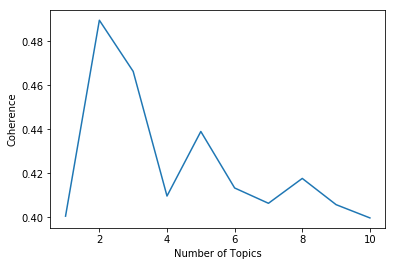

2018-06-28 15:09:31,727 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows


The Best model has 2 topics with 0.489556014739 coherence.


2018-06-28 15:09:31,790 : INFO : 1 batches submitted to accumulate stats from 64 documents (14521 virtual)
2018-06-28 15:09:31,808 : INFO : 2 batches submitted to accumulate stats from 128 documents (27361 virtual)
2018-06-28 15:09:31,824 : INFO : 3 batches submitted to accumulate stats from 192 documents (40706 virtual)
2018-06-28 15:09:31,841 : INFO : 4 batches submitted to accumulate stats from 256 documents (53801 virtual)
2018-06-28 15:09:31,846 : INFO : 5 batches submitted to accumulate stats from 320 documents (55414 virtual)
2018-06-28 15:09:31,851 : INFO : serializing accumulator to return to master...
2018-06-28 15:09:31,860 : INFO : serializing accumulator to return to master...
2018-06-28 15:09:31,868 : INFO : accumulator serialized
2018-06-28 15:09:31,876 : INFO : accumulator serialized
2018-06-28 15:09:31,940 : INFO : serializing accumulator to return to master...
2018-06-28 15:09:31,945 : INFO : accumulator serialized
2018-06-28 15:09:32,272 : INFO : serializing accumula

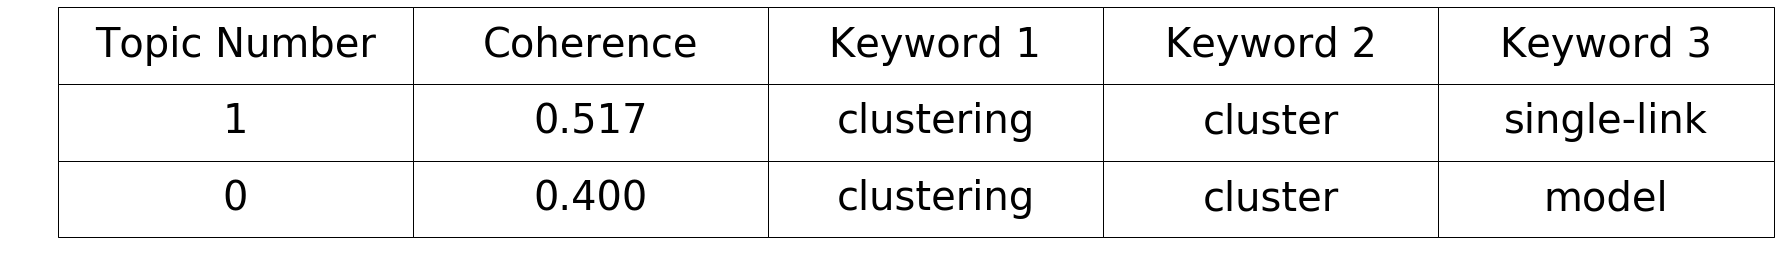

In [10]:
#choose model with best number of topics LSI

numTopicsToShow = 25

textPreprocessingLevel = 2

tokenizedCorpus = tokenizeCorpus(corpusList, 'stopwords.txt')
dictionary = corpora.Dictionary(tokenizedCorpus)
    
theCorpus = MyCorpus.createCorpus(corpusList)
    
tfidf = models.TfidfModel(theCorpus)
corpus_tfidf = tfidf[theCorpus]

lm_list_cv = evaluateLSINumTopicsGraph(dictionary, corpus_tfidf, tokenizedCorpus, 75)
bestModel = getBestModelFromEvalBestTopic(lm_list_cv)

numTopics = bestModel.num_topics

if(numTopics < numTopicsToShow):
    numTopicsToShow = numTopics

#Table produced by this code is written to "./figures/Best_LSI.csv"
showBestTopics(bestModel, tokenizedCorpus, dictionary, 110, numTopicsToShow, 10, 'Best_LSI')


### LDA

2018-06-28 15:13:48,516 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-06-28 15:13:48,594 : INFO : built Dictionary(7370 unique tokens: ['allow', 'aspect', 'broader', 'comment', 'complete']...) from 289 documents (total 87155 corpus positions)
2018-06-28 15:13:48,595 : INFO : collecting document frequencies
2018-06-28 15:13:48,597 : INFO : PROGRESS: processing document #0
2018-06-28 15:13:49,646 : INFO : calculating IDF weights for 289 documents and 7369 features (47298 matrix non-zeros)
2018-06-28 15:13:49,671 : INFO : using autotuned alpha, starting with [1.0]
2018-06-28 15:13:49,674 : INFO : using serial LDA version on this node
2018-06-28 15:13:49,676 : INFO : running online (multi-pass) LDA training, 1 topics, 5 passes over the supplied corpus of 289 documents, updating model once every 289 documents, evaluating perplexity every 289 documents, iterating 250x with a convergence threshold of 0.001000
2018-06-28 15:13:49,677 : WARNING : too few updates, training 


===========================     Training on 1 topics     ===========================



2018-06-28 15:13:51,466 : INFO : -9.524 per-word bound, 736.3 perplexity estimate based on a held-out corpus of 289 documents with 2511 words
2018-06-28 15:13:51,467 : INFO : PROGRESS: pass 0, at document #289/289
2018-06-28 15:13:51,529 : INFO : optimized alpha [1.0]
2018-06-28 15:13:51,535 : INFO : topic #0 (1.000): 0.001*"clustering" + 0.001*"query" + 0.001*"model" + 0.001*"cluster" + 0.001*"relevance" + 0.001*"classification" + 0.001*"feature" + 0.001*"vector" + 0.001*"document" + 0.001*"feedback"
2018-06-28 15:13:51,537 : INFO : topic diff=0.297272, rho=1.000000
2018-06-28 15:13:53,507 : INFO : -8.794 per-word bound, 443.7 perplexity estimate based on a held-out corpus of 289 documents with 2511 words
2018-06-28 15:13:53,508 : INFO : PROGRESS: pass 1, at document #289/289
2018-06-28 15:13:53,568 : INFO : optimized alpha [1.0]
2018-06-28 15:13:53,574 : INFO : topic #0 (1.000): 0.001*"clustering" + 0.001*"query" + 0.001*"model" + 0.001*"cluster" + 0.001*"relevance" + 0.001*"classifi


===========================     Training on 2 topics     ===========================



2018-06-28 15:14:02,951 : INFO : -11.065 per-word bound, 2142.3 perplexity estimate based on a held-out corpus of 289 documents with 2511 words
2018-06-28 15:14:02,952 : INFO : PROGRESS: pass 0, at document #289/289
2018-06-28 15:14:03,935 : INFO : optimized alpha [0.80333018, 0.81086767]
2018-06-28 15:14:03,941 : INFO : topic #0 (0.803): 0.001*"clustering" + 0.001*"query" + 0.001*"classification" + 0.001*"cluster" + 0.001*"web" + 0.001*"feedback" + 0.001*"classifier" + 0.001*"vector" + 0.001*"zone" + 0.001*"document"
2018-06-28 15:14:03,942 : INFO : topic #1 (0.811): 0.001*"model" + 0.001*"clustering" + 0.001*"relevance" + 0.001*"query" + 0.001*"posting" + 0.001*"cluster" + 0.001*"feature" + 0.001*"index" + 0.001*"term" + 0.001*"language"
2018-06-28 15:14:03,944 : INFO : topic diff=0.652396, rho=1.000000
2018-06-28 15:14:05,982 : INFO : -9.287 per-word bound, 624.5 perplexity estimate based on a held-out corpus of 289 documents with 2511 words
2018-06-28 15:14:05,983 : INFO : PROGRESS


===========================     Training on 3 topics     ===========================



2018-06-28 15:14:16,127 : INFO : -13.354 per-word bound, 10469.0 perplexity estimate based on a held-out corpus of 289 documents with 2511 words
2018-06-28 15:14:16,128 : INFO : PROGRESS: pass 0, at document #289/289
2018-06-28 15:14:16,749 : INFO : optimized alpha [0.28894579, 0.22468711, 0.21134426]
2018-06-28 15:14:16,756 : INFO : topic #0 (0.289): 0.002*"clustering" + 0.002*"cluster" + 0.002*"query" + 0.001*"zone" + 0.001*"vector" + 0.001*"posting" + 0.001*"model" + 0.001*"document" + 0.001*"search" + 0.001*"term"
2018-06-28 15:14:16,757 : INFO : topic #1 (0.225): 0.001*"class" + 0.001*"probability" + 0.001*"model" + 0.001*"classification" + 0.001*"posting" + 0.001*"classifier" + 0.001*"language" + 0.001*"feature" + 0.001*"index" + 0.001*"term"
2018-06-28 15:14:16,758 : INFO : topic #2 (0.211): 0.001*"relevance" + 0.001*"feature" + 0.001*"query" + 0.001*"feedback" + 0.001*"crawler" + 0.001*"model" + 0.001*"relevant" + 0.001*"web" + 0.001*"probability" + 0.001*"document"
2018-06-28 

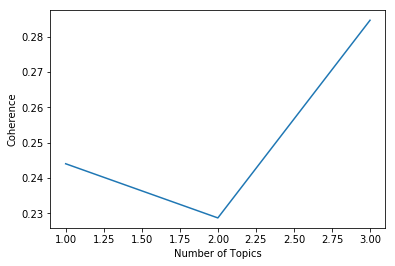

2018-06-28 15:14:26,356 : INFO : using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows


The Best model has 3 topics with 0.284644954051 coherence.


2018-06-28 15:14:26,403 : INFO : 1 batches submitted to accumulate stats from 64 documents (14521 virtual)
2018-06-28 15:14:26,416 : INFO : 2 batches submitted to accumulate stats from 128 documents (27645 virtual)
2018-06-28 15:14:26,427 : INFO : 3 batches submitted to accumulate stats from 192 documents (40707 virtual)
2018-06-28 15:14:26,437 : INFO : 4 batches submitted to accumulate stats from 256 documents (53984 virtual)
2018-06-28 15:14:26,442 : INFO : 5 batches submitted to accumulate stats from 320 documents (55757 virtual)
2018-06-28 15:14:26,445 : INFO : serializing accumulator to return to master...
2018-06-28 15:14:26,446 : INFO : serializing accumulator to return to master...
2018-06-28 15:14:26,453 : INFO : accumulator serialized
2018-06-28 15:14:26,456 : INFO : accumulator serialized
2018-06-28 15:14:26,526 : INFO : serializing accumulator to return to master...
2018-06-28 15:14:26,532 : INFO : accumulator serialized
2018-06-28 15:14:26,799 : INFO : serializing accumula

In [14]:
#choose model with best number of topics LDA

numTopicsToShow = 25

textPreprocessingLevel = 2

tokenizedCorpus = tokenizeCorpus(corpusList, 'stopwords.txt')
dictionary = corpora.Dictionary(tokenizedCorpus)
    
theCorpus = MyCorpus.createCorpus(corpusList)
    
tfidf = models.TfidfModel(theCorpus)
corpus_tfidf = tfidf[theCorpus]
 
lm_list_cv = evaluateLDANumTopicsGraph(dictionary, corpus_tfidf, tokenizedCorpus, 3)
bestModel = getBestModelFromEvalBestTopic(lm_list_cv)

numTopics = bestModel.num_topics

if(numTopics < numTopicsToShow):
    numTopicsToShow = numTopics

#Table produced by this code is written to "./figures/Best_LDA.csv"
showBestTopics(bestModel, tokenizedCorpus, dictionary, 110, numTopicsToShow, 10, 'Best_LDA')
    

## Bibliography
References are listed as they appear in the notebook